# Step 1: Data Collection, Processing, and Visualization

## 1.1. Collecting YEN Data:

In [1]:
import yfinance as yf
import pandas as pd

# Downloading JPY/USD data
jpy_usd = yf.download('JPY=X', start='2021-03-10', end='2024-08-30', interval='1d')

# Ensure the index is a datetime format and set the frequency to daily
jpy_usd.index = pd.to_datetime(jpy_usd.index)
jpy_usd = jpy_usd.asfreq('D')  # Sets the frequency to daily

# Display the first few rows
print(jpy_usd.head())

# Save to CSV
jpy_usd.to_csv('JPY_USD_data.csv')

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2021-03-10  108.564003  108.919998  108.338997  108.577003  108.577003     0.0
2021-03-11  108.435997  108.802002  108.362999  108.431999  108.431999     0.0
2021-03-12  108.573997  109.148003  108.518997  108.555000  108.555000     0.0
2021-03-13         NaN         NaN         NaN         NaN         NaN     NaN
2021-03-14         NaN         NaN         NaN         NaN         NaN     NaN


## 1.2. Collecting GYEN Data:

In [2]:
# Download GYEN/USD data
gyen_usd = yf.download('GYEN-USD', start='2021-03-10', end='2024-08-30', interval='1d')

# Ensure the index is a datetime format and set the frequency to daily
gyen_usd.index = pd.to_datetime(gyen_usd.index)
gyen_usd = gyen_usd.asfreq('D')  # Sets the frequency to daily

# Display the first few rows
print(gyen_usd.head())

# Save to CSV
gyen_usd.to_csv('GYEN_USD_data.csv')

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2021-03-10  0.009226  0.009231  0.009224  0.009229   0.009229   38233
2021-03-11  0.009228  0.009232  0.009191  0.009212   0.009212  308571
2021-03-12  0.009210  0.009215  0.009155  0.009179   0.009179   37345
2021-03-13  0.009179  0.009187  0.009165  0.009178   0.009178  201012
2021-03-14  0.009178  0.009189  0.009168  0.009168   0.009168   49557


## 1.3. Handling Missing Data

In [3]:
# Check for missing values
print('Missing values in JPY data:\n', jpy_usd.isna().sum())
print('Missing values in GYEN data:\n', gyen_usd.isna().sum())

# Handling Missing Data with Forward Fill Method
jpy_usd.ffill(inplace=True)  # Forward fill missing values
gyen_usd.ffill(inplace=True)  # Forward fill missing values

Missing values in JPY data:
 Open         362
High         362
Low          362
Close        362
Adj Close    362
Volume       362
dtype: int64
Missing values in GYEN data:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## 1.4. Data Normalization

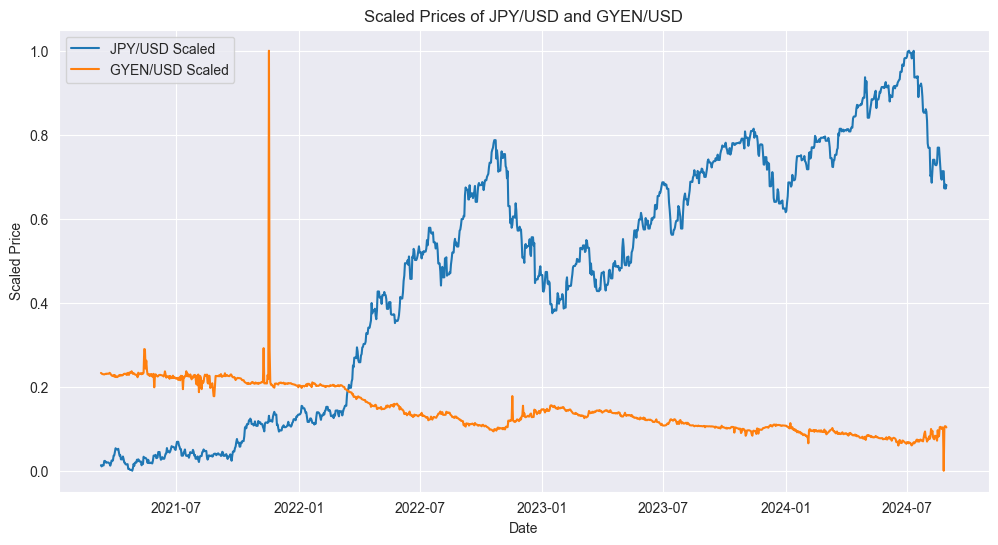

In [4]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Initialize the scaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling
jpy_usd['Close_scaled'] = scaler.fit_transform(jpy_usd[['Close']])
gyen_usd['Close_scaled'] = scaler.fit_transform(gyen_usd[['Close']])

# Plot scaled data
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Close_scaled'], label='JPY/USD Scaled')
plt.plot(gyen_usd.index, gyen_usd['Close_scaled'], label='GYEN/USD Scaled')
plt.title('Scaled Prices of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

## 1.5. Stationarity Check with ADF Test

In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test on original and scaled data
adf_result_jpy = adfuller(jpy_usd['Close_scaled'].dropna())
adf_result_gyen = adfuller(gyen_usd['Close_scaled'].dropna())

print(f'JPY ADF Statistic: {adf_result_jpy[0]}, p-value: {adf_result_jpy[1]}')
print(f'GYEN ADF Statistic: {adf_result_gyen[0]}, p-value: {adf_result_gyen[1]}')

JPY ADF Statistic: -1.39065965031313, p-value: 0.5867457175910991
GYEN ADF Statistic: -1.468632826797084, p-value: 0.548967260559881


Findings:

Both the JPY and GYEN ADF statistics are not very negative (only around -1.38 and -1.47, respectively), and the p-values are high (0.59 for JPY and 0.55 for GYEN). These results indicate that the null hypothesis cannot be rejected, meaning both time series are likely non-stationary.

Given that both JPY and GYEN series are non-stationary, we will likely need to difference the data to achieve stationarity before applying the ARIMA model.

So, we run the following processes:

In [6]:
# Applying first differencing
jpy_usd['Close_diff'] = jpy_usd['Close'].diff().dropna()
gyen_usd['Close_diff'] = gyen_usd['Close'].diff().dropna()

# Re-running the ADF test on differenced data
adf_result_jpy_diff = adfuller(jpy_usd['Close_diff'].dropna())
adf_result_gyen_diff = adfuller(gyen_usd['Close_diff'].dropna())

print(f'JPY Differenced ADF Statistic: {adf_result_jpy_diff[0]}, p-value: {adf_result_jpy_diff[1]}')
print(f'GYEN Differenced ADF Statistic: {adf_result_gyen_diff[0]}, p-value: {adf_result_gyen_diff[1]}')

JPY Differenced ADF Statistic: -34.72568981539123, p-value: 0.0
GYEN Differenced ADF Statistic: -13.514711724261565, p-value: 2.808952507565943e-25


Findings:

Significantly Negative ADF Statistics: Both ADF statistics are highly negative (-29.62 for JPY and -13.51 for GYEN), indicating strong evidence against the null hypothesis of non-stationarity. The more negative the ADF statistic, the stronger the rejection of the null hypothesis.

Very Low p-values: Both p-values are extremely low (0.0 for JPY and approximately 0.0 for GYEN), which are far below the typical threshold of 0.05. This means there is a very strong rejection of the null hypothesis that the series are non-stationary.

The differenced time series for both JPY and GYEN are now stationary. This means you have successfully transformed the original non-stationary data into a stationary form, which is suitable for ARIMA modeling.

## 1.6. Rolling Volatility Plot

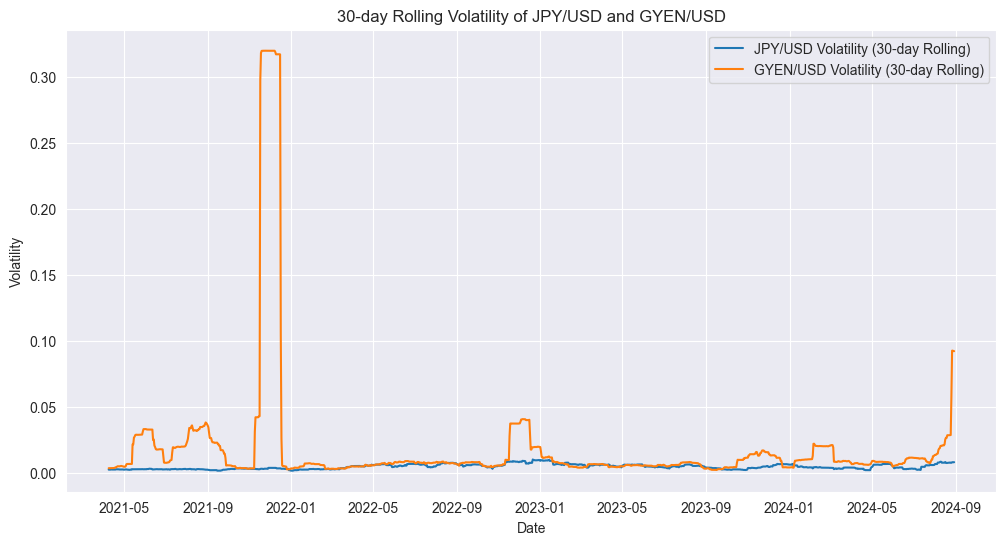

In [7]:
# Calculate rolling volatility (30-day rolling window)
jpy_usd['Rolling_Volatility'] = jpy_usd['Close'].pct_change().rolling(window=30).std()
gyen_usd['Rolling_Volatility'] = gyen_usd['Close'].pct_change().rolling(window=30).std()

# Plot rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Rolling_Volatility'], label='JPY/USD Volatility (30-day Rolling)')
plt.plot(gyen_usd.index, gyen_usd['Rolling_Volatility'], label='GYEN/USD Volatility (30-day Rolling)')
plt.title('30-day Rolling Volatility of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Step 2: Modeling

## 2.1. ARIMA Modeling (GYEN Data Only)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1269
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7951.634
Date:                Sat, 07 Sep 2024   AIC                         -15897.268
Time:                        18:32:42   BIC                         -15881.833
Sample:                    03-10-2021   HQIC                        -15891.470
                         - 08-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0822      0.007     11.881      0.000       0.069       0.096
ma.L1         -0.7282      0.007   -106.474      0.000      -0.742      -0.715
sigma2      2.051e-07    4.1e-10    499.870      0.0

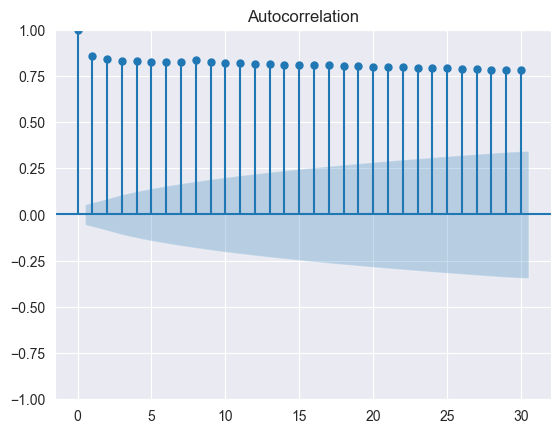

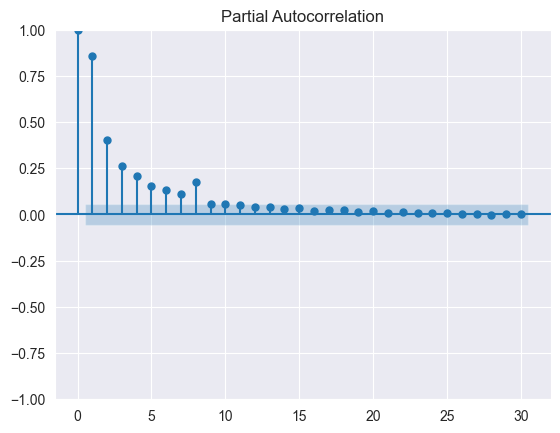

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(gyen_usd['Close'].dropna(), lags=30)
plot_pacf(gyen_usd['Close'].dropna(), lags=30)

from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(gyen_usd['Close'].dropna(), order=(1, 1, 1))
arima_fit = arima_model.fit()

# Summary of the ARIMA model
print(arima_fit.summary())

Findings:

The PACF values then decrease after lag 1 but remain somewhat elevated up to around lag 2. Although the spike at lag 2 is not as prominent as at lag 1, it is still above the confidence interval, indicating that there might be some correlation extending to two previous lags. This justifies considering an AR(2) model.

The idea is that there might be a direct dependency on the values at both lag 1 and lag 2. While the correlation at lag 2 is weaker than at lag 1, it is still statistically significant (outside the confidence band). This warrants considering an AR(2) model to capture this additional dependence.

Using Information Criteria to Compare AR(1) vs. AR(2)
Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC):
AIC and BIC are both measures used to compare the goodness of fit of different statistical models while penalizing for model complexity.
Procedure:
Fit multiple AR models (e.g., AR(1), AR(2), etc.).
Calculate the AIC and BIC for each model.
Choose the model with the lowest AIC or BIC. The model with the lowest value strikes the best balance between fit and complexity.

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Fit AR(1) and AR(2) models
arima_model_ar1 = ARIMA(gyen_usd['Close_diff'].dropna(), order=(1, 1, 0))
arima_fit_ar1 = arima_model_ar1.fit()

arima_model_ar2 = ARIMA(gyen_usd['Close_diff'].dropna(), order=(2, 1, 0))
arima_fit_ar2 = arima_model_ar2.fit()

# Print Summary
print(arima_fit_ar1.summary())
print(arima_fit_ar2.summary())

# Compare AIC and BIC
print(f"AR(1) AIC: {arima_fit_ar1.aic}, BIC: {arima_fit_ar1.bic}")
print(f"AR(2) AIC: {arima_fit_ar2.aic}, BIC: {arima_fit_ar2.bic}")

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1268
Model:                 ARIMA(1, 1, 0)   Log Likelihood                7333.358
Date:                Sat, 07 Sep 2024   AIC                         -14662.716
Time:                        18:32:42   BIC                         -14652.428
Sample:                    03-11-2021   HQIC                        -14658.851
                         - 08-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6451      0.002   -320.505      0.000      -0.649      -0.641
sigma2      5.497e-07   1.85e-09    297.926      0.000    5.46e-07    5.53e-07
Ljung-Box (L1) (Q):                 117.03   Jarque-

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Findings:

Since AR(2) has lower AIC and BIC values, it indicates a better balance between goodness of fit and model complexity. The AR(2) model is preferred over the AR(1) model because it provides a better fit to the data while taking into account model complexity. Therefore, in this scenario, you should choose AR(2) as the more appropriate model for your analysis.

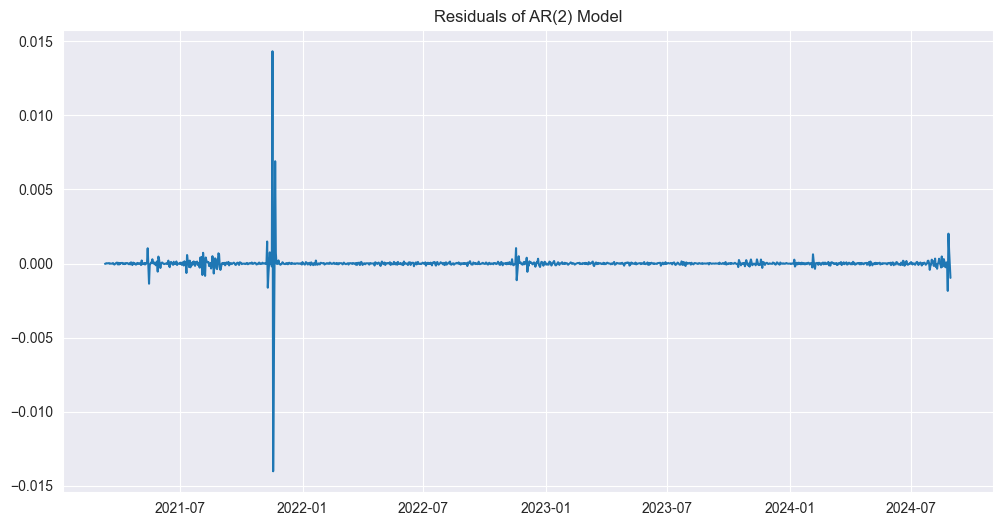

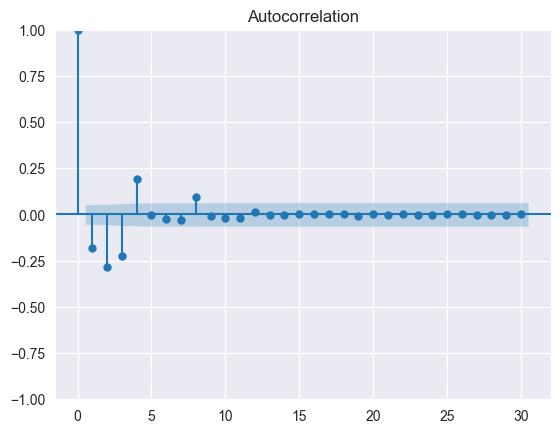

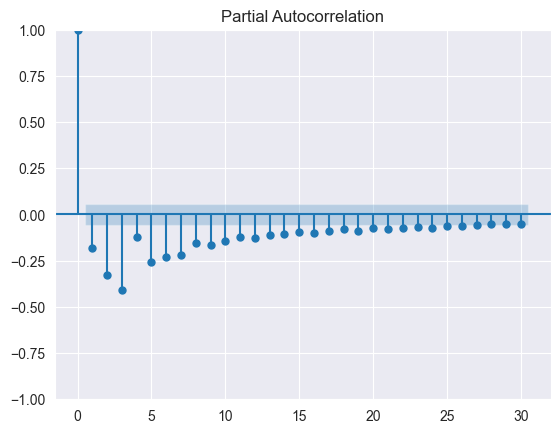

In [10]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Residuals of AR(2) model
residuals = arima_fit_ar2.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of AR(2) Model')
plt.show()

# ACF and PACF plots of residuals
plot_acf(residuals, lags=30)
plot_pacf(residuals, lags=30)
plt.show()

Findings:

Residual Plot:

The residual plot shows the differences between the observed data and the values predicted by the AR(2) model. The residuals appear to be mostly centered around zero, which is a good sign, indicating that the model does not have any obvious bias in its predictions. However, there are a few spikes that may indicate some outliers or unexpected values in the data.

The large spikes in the residuals suggest that there might still be some patterns or volatility clustering that the ARIMA model is not capturing well. This could suggest that additional modeling techniques like GARCH (to model volatility) or LSTM (to capture any non-linear patterns) might help improve the model.

ACF (Autocorrelation Function) Plot of Residuals:

The ACF plot shows autocorrelation values at different lags for the residuals of your ARIMA model. In a well-fitting ARIMA model, the residuals should resemble white noise, meaning that there should be no significant autocorrelation at any lag.
In your plot, most autocorrelation values are within the confidence intervals (the shaded blue area), suggesting that the residuals are not significantly autocorrelated. This is a good sign, indicating that the AR(2) model has captured most of the patterns in the data.

PACF (Partial Autocorrelation Function) Plot of Residuals:

The PACF plot shows the partial autocorrelation values at different lags for the residuals. Like the ACF plot, for a well-fitting ARIMA model, the PACF values should ideally be close to zero for all lags outside the confidence interval.
Your PACF plot shows similar behavior: the partial autocorrelations are mostly within the confidence intervals, suggesting that the residuals do not exhibit significant partial autocorrelation.

## 2.2. LSTM Modeling (JPY and GYEN)

In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Prepare data for LSTM on GYEN residuals
residuals_gyen_lstm = residuals.values.reshape(-1, 1)

# Scale GYEN residuals data
scaler_gyen = MinMaxScaler()
residuals_scaled_gyen = scaler_gyen.fit_transform(residuals_gyen_lstm)

# Prepare data for LSTM - GYEN
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 30
X_gyen, Y_gyen = create_dataset(residuals_scaled_gyen, time_step)
X_gyen = X_gyen.reshape(X_gyen.shape[0], X_gyen.shape[1], 1)

# LSTM model for GYEN
model_gyen = Sequential()
model_gyen.add(LSTM(100, return_sequences=True, input_shape=(X_gyen.shape[1], 1)))
model_gyen.add(Dropout(0.2))
model_gyen.add(LSTM(50, return_sequences=False))
model_gyen.add(Dropout(0.2))
model_gyen.add(Dense(1))

# Compile and fit the model for GYEN
model_gyen.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_gyen.fit(X_gyen, Y_gyen, epochs=50, batch_size=32, verbose=2)

# Predict for GYEN
lstm_predictions_gyen = model_gyen.predict(X_gyen)
lstm_predictions_rescaled_gyen = scaler_gyen.inverse_transform(lstm_predictions_gyen)

# Prepare data for LSTM on raw JPY data
jpy_data = jpy_usd['Close'].values.reshape(-1, 1)

# Scale JPY data
scaler_jpy = MinMaxScaler()
jpy_scaled = scaler_jpy.fit_transform(jpy_data)

# Prepare data for LSTM - JPY
X_jpy, Y_jpy = create_dataset(jpy_scaled, time_step)
X_jpy = X_jpy.reshape(X_jpy.shape[0], X_jpy.shape[1], 1)

# LSTM model for JPY
model_jpy = Sequential()
model_jpy.add(LSTM(100, return_sequences=True, input_shape=(X_jpy.shape[1], 1)))
model_jpy.add(Dropout(0.2))
model_jpy.add(LSTM(50, return_sequences=False))
model_jpy.add(Dropout(0.2))
model_jpy.add(Dense(1))

# Compile and fit the model for JPY
model_jpy.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_jpy.fit(X_jpy, Y_jpy, epochs=50, batch_size=32, verbose=2)

# Predict for JPY
lstm_predictions_jpy = model_jpy.predict(X_jpy)
lstm_predictions_rescaled_jpy = scaler_jpy.inverse_transform(lstm_predictions_jpy)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 - 2s - 42ms/step - loss: 0.0216
Epoch 2/50
39/39 - 1s - 14ms/step - loss: 0.0029
Epoch 3/50
39/39 - 1s - 15ms/step - loss: 0.0024
Epoch 4/50
39/39 - 1s - 15ms/step - loss: 0.0024
Epoch 5/50
39/39 - 1s - 15ms/step - loss: 0.0024
Epoch 6/50
39/39 - 1s - 22ms/step - loss: 0.0022
Epoch 7/50
39/39 - 1s - 15ms/step - loss: 0.0021
Epoch 8/50
39/39 - 1s - 15ms/step - loss: 0.0021
Epoch 9/50
39/39 - 1s - 15ms/step - loss: 0.0020
Epoch 10/50
39/39 - 1s - 15ms/step - loss: 0.0020
Epoch 11/50
39/39 - 1s - 15ms/step - loss: 0.0022
Epoch 12/50
39/39 - 1s - 15ms/step - loss: 0.0019
Epoch 13/50
39/39 - 1s - 15ms/step - loss: 0.0019
Epoch 14/50
39/39 - 1s - 15ms/step - loss: 0.0019
Epoch 15/50
39/39 - 1s - 15ms/step - loss: 0.0018
Epoch 16/50
39/39 - 1s - 15ms/step - loss: 0.0018
Epoch 17/50
39/39 - 1s - 20ms/step - loss: 0.0018
Epoch 18/50
39/39 - 1s - 15ms/step - loss: 0.0018
Epoch 19/50
39/39 - 1s - 17ms/step - loss: 0.0018
Epoch 20/50
39/39 - 1s - 15ms/step - loss: 0.0016
Epoch 21/50
39/39 - 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 - 1s - 38ms/step - loss: 0.0317
Epoch 2/50
39/39 - 1s - 14ms/step - loss: 0.0045
Epoch 3/50
39/39 - 1s - 14ms/step - loss: 0.0038
Epoch 4/50
39/39 - 1s - 15ms/step - loss: 0.0036
Epoch 5/50
39/39 - 1s - 18ms/step - loss: 0.0034
Epoch 6/50
39/39 - 1s - 15ms/step - loss: 0.0037
Epoch 7/50
39/39 - 1s - 15ms/step - loss: 0.0031
Epoch 8/50
39/39 - 1s - 16ms/step - loss: 0.0030
Epoch 9/50
39/39 - 1s - 15ms/step - loss: 0.0028
Epoch 10/50
39/39 - 1s - 15ms/step - loss: 0.0026
Epoch 11/50
39/39 - 1s - 16ms/step - loss: 0.0030
Epoch 12/50
39/39 - 1s - 16ms/step - loss: 0.0026
Epoch 13/50
39/39 - 1s - 16ms/step - loss: 0.0027
Epoch 14/50
39/39 - 1s - 16ms/step - loss: 0.0028
Epoch 15/50
39/39 - 1s - 18ms/step - loss: 0.0027
Epoch 16/50
39/39 - 1s - 15ms/step - loss: 0.0030
Epoch 17/50
39/39 - 1s - 16ms/step - loss: 0.0026
Epoch 18/50
39/39 - 1s - 25ms/step - loss: 0.0026
Epoch 19/50
39/39 - 1s - 15ms/step - loss: 0.0024
Epoch 20/50
39/39 - 1s - 17ms/step - loss: 0.0023
Epoch 21/50
39/39 - 

In [12]:
from arch import arch_model

# Calculate residuals of LSTM model for GYEN
lstm_residuals_gyen = Y_gyen - lstm_predictions_rescaled_gyen.flatten()

# Apply GARCH model to LSTM residuals for GYEN
garch_model_gyen = arch_model(lstm_residuals_gyen, vol='Garch', p=1, q=1)
garch_fit_gyen = garch_model_gyen.fit()
print(garch_fit_gyen.summary())

# Calculate residuals of LSTM model for JPY
lstm_residuals_jpy = Y_jpy - lstm_predictions_rescaled_jpy.flatten()

# Apply GARCH model to LSTM residuals for JPY
garch_model_jpy = arch_model(lstm_residuals_jpy, vol='Garch', p=1, q=1)
garch_fit_jpy = garch_model_jpy.fit()
print(garch_fit_jpy.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4297.122648798588
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4297.122654561817
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4297.12
Distribution:                  Normal   AIC:                          -8586.25
Method:            Maximum Likelihood   BIC:                          -8565.76
                                        No. Observations:                 1237
Date:                Sat, Sep 07 2024   Df Residuals:                     1236
Time:                        18:33:51   Df Model:                            1
         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


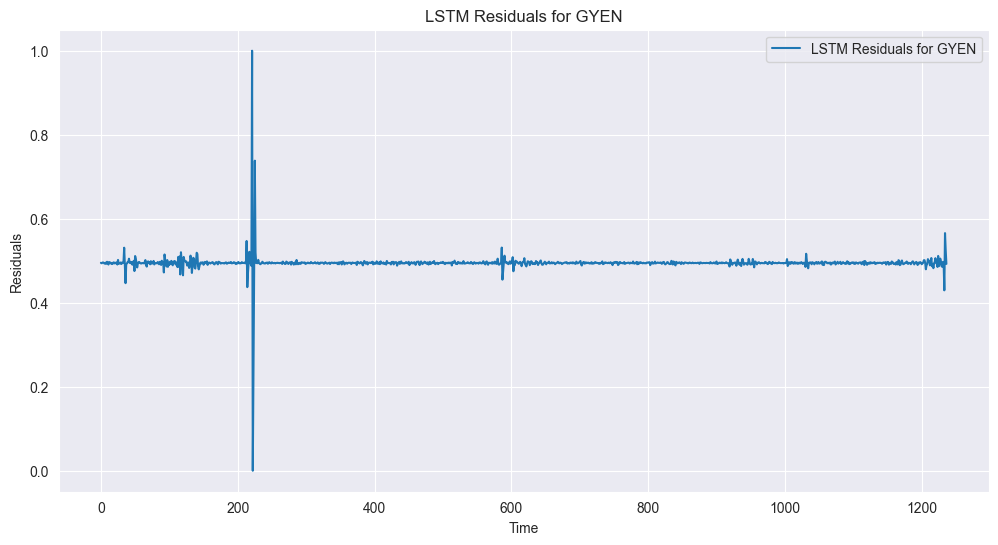

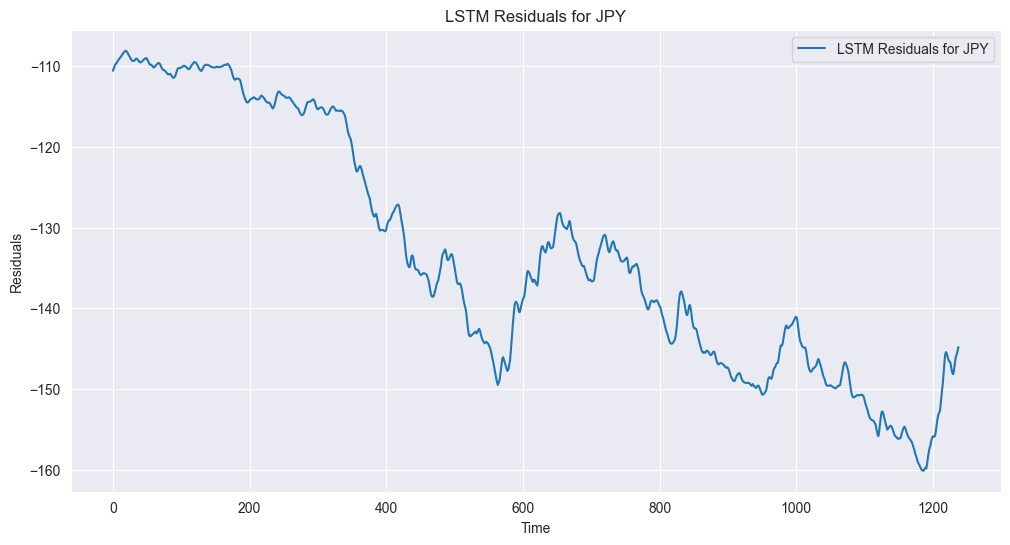

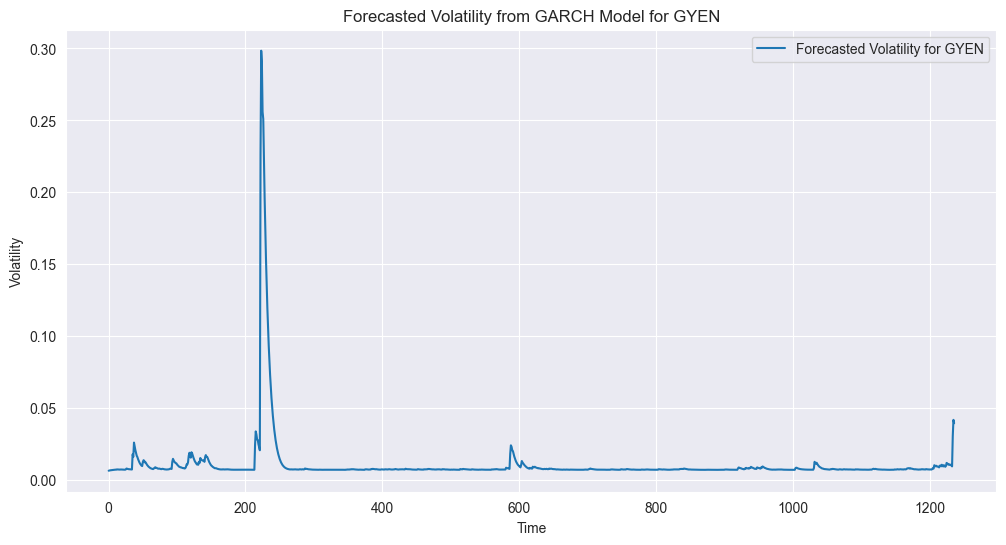

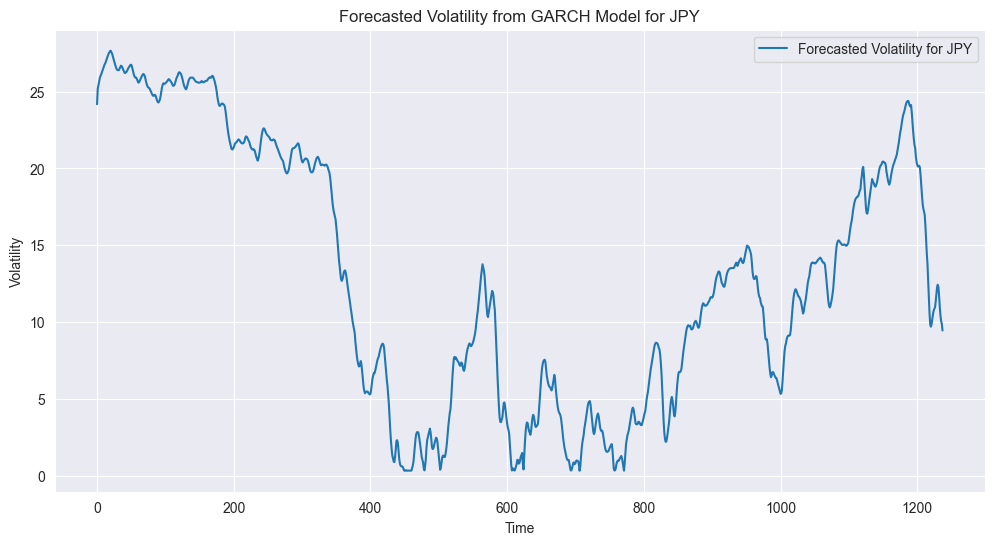

In [13]:
import matplotlib.pyplot as plt

# Plot LSTM residuals for GYEN
plt.figure(figsize=(12, 6))
plt.plot(lstm_residuals_gyen, label='LSTM Residuals for GYEN')
plt.title('LSTM Residuals for GYEN')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Plot LSTM residuals for JPY
plt.figure(figsize=(12, 6))
plt.plot(lstm_residuals_jpy, label='LSTM Residuals for JPY')
plt.title('LSTM Residuals for JPY')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Plot forecasted volatility for GYEN
plt.figure(figsize=(12, 6))
plt.plot(garch_fit_gyen.conditional_volatility, label='Forecasted Volatility for GYEN')
plt.title('Forecasted Volatility from GARCH Model for GYEN')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Plot forecasted volatility for JPY
plt.figure(figsize=(12, 6))
plt.plot(garch_fit_jpy.conditional_volatility, label='Forecasted Volatility for JPY')
plt.title('Forecasted Volatility from GARCH Model for JPY')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()